In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pickle
import numpy as  np
import matplotlib.pyplot as plt
import cv2
import time 
import PIL
from IPython import display

In [2]:
BATCH_SIZE = 32

In [3]:
def dataset_prep():
    data = pickle.load(open("X.pickle", "rb"))
    train_dataset = tf.data.Dataset.from_tensor_slices(data).batch(BATCH_SIZE)
    return train_dataset


In [4]:
def Generator():
    model =  tf.keras.Sequential()
    
    model.add(layers.Dense(80*80*128,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

        
    model.add(layers.Reshape((80,80,128)))
    
    
    model.add(layers.Conv2DTranspose(32,(5,5),strides =(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(16,(5,5),strides = (1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(3,(3,3),strides = (1,1),activation = 'tanh'))
    
    return model

In [5]:
def Discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(62,(3,3), input_shape = (90,90,3),strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(32,(3,3),strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(32,(3,3),strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(16,(3,3),strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.1))
    

    model.add(layers.Flatten())
    
    model.add(layers.Dense(1))
    
    return model

In [6]:
G = Generator()
D = Discriminator()

In [7]:
def DiscriminatorLoss(real_output,fake_output):
     loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
     return loss

In [8]:
def GeneratorLoss(fake_output):
    return -tf.reduce_mean(fake_output)

In [9]:
GeneratorOptimizer = tf.keras.optimizers.Adam(1e-4)
DiscriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
Epochs = 1500

noise_dim = 100

num_examples_to_generate = 16

In [11]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = G(noise, training=True)

      real_output = D(images, training=True)
      fake_output = D(generated_images, training=True)

      gen_loss = GeneratorLoss(fake_output)
      disc_loss = DiscriminatorLoss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

    GeneratorOptimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    DiscriminatorOptimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

In [13]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(G,
                             epoch + 1,seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(G,
                           epochs,
                           seed)

In [14]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      m = tf.reduce_max(predictions)
      mi = tf.reduce_min(predictions)
      predictions = (predictions - mi)/(m-mi)
      plt.imshow(predictions[i, :, :,:])
      plt.axis('off')
  if(epoch%50==0):
   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
X = dataset_prep()

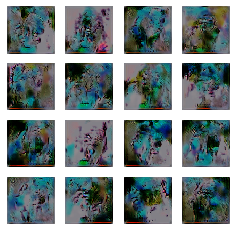

In [16]:
train(X,Epochs)